# Recommender System Implementation
To ensure a high quality baseline for our own understanding of recommender systems as well as our comparison, we began our evaluation of recommender systems under a variety of matrix factorization steps for completing the user item matrix and finished by experimenting on how we can introduce hybrid filtering techniques in our recommendations. For our matrix factorization methods we implemented gradient descent, alternating least squares and the generalization of matrix factorization as released in 2010, factorization machines. Factorization machines were implemented mathematically and with a framework that could better compute the necessary elements, fastFM.

## Utilizing clustering
Under gradient descent and alternating least squares we use a user-item matrix $R$ which via clustering we experimented on. Two different types of the user-item ratings matrix $R$ were used for our baseline, one using user clustering and the other using item clustering. By setting up $R$ in this way we avoided challenges brought on by the binary nature of our data's ratings by increasing the maximum score a rating can achieve.

### Ratings calculations for Item and User Clusters
The ratings for user $u_i$ in an item cluster $IC$ is denoted as $IC_i$ and is calculated as the sum of all interactions that user $u_i$ had with various items in the cluster. Mathematically, it can be expressed as:
$$
IC_{i} = \sum_{j=1}^{n} I_{ij}
$$
The ratings for item $v_{j}$ in a user cluster $UC$ is denoted as $UC_{j}$ and is calculated as the sum of all interactions that users in the cluster had with item $v_{j}$. Mathematically, it can be expressed as:
$$
UC_{j} = \sum_{i=1}^{m} I_{ij}
$$

Under both user and item clustering:
- $n$ or $m$ represent the total number of items in a cluster,
- $I_{ij}$ is a binary indicator defined as follows $ I_{ij} = \begin{cases} 1, & \text{if user } u_{i} \text{ has interacted with item } v_{j} \\ 
0, & \text{otherwise} \end{cases}
$

# Ranking
Ranking is the step where we take a sparse set of ratings, $R$, and try to predict what unknown ratings are, $\hat{R}$.

For matrix factorization techniques, predicting ratings is formulated as the following non-convex optimization problem which seeks to minimize least squared error and use regularization to avoid overfitting:

$$\min_{U,V} \sum_{r_{ij} \text{observed}}{(r_{ij}-u_{i}^Tv_{j})^2} + \lambda(\sum_{i}\|u_i\|^2 + \sum_{j}\|v_j\|^2)$$ 

### Adding Features 
To utilize complex features we experimented with appending user and item features to their corresponding latent factor matrices, $U$ and $V$. Under ALS respective features were concatenated to the bottom of $U$ and $V$ whereas in SGD the features were concatenated to the right side.

## Gradient Descent
### Introduction
Under gradient descent, we create partial derivatives of the aformentioned function with respect to $u_i$ and $v_j$ to acquire update functions for each vector. Using these update functions each vector in U and V at indices corresponding to observed ratings are updated.

The update formulae for $u_i$ and $v_j$ with $i$ and $j$ corresponding to the row and column of an observed rating, are as follows:

$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha (r_{ij} -  v_j u_i^T)\cdot v_j - 2\alpha\lambda u_i\\
v_j^{\text{new}} &= v_j + 2\alpha (r_{ij} -  v_j u_i^T)\cdot u_i - 2\alpha\lambda v_j
\end{aligned}
$$

### Implementation
Our implementation of gradient descent for ratings matrix predictions is simple; iterate over the indices of all observed ratings updating corresponding rows in U and V at each rating. During this process we track the updates so that we can stop the training loop early if the algorithm starts to converge.

## Alternating Least Squares
### Introduction
Alternating Least Squares, or ALS, is another method of matrix factorization similar to gradient descent with one key difference; instead of updating by vector, entire matrices $U$ and $V$ alternate as a fixed variable while optimizing the other. Our implementation of ALS was based off of lecture 14 from CME 323: Distributed Algorithms and Optimization, Spring 2015 from Stanford. Under our implementation of ALS from Stanford the user and item matrices $U$ and $V$ both are of dimension $k$ x $n$ and $k$ x $m$ respectively. The complete ratings matrix $R$ is thus estimated via $\hat{R} = U^TV$. 

Compared to gradient descent, ALS is faster and requires less iterations. By fixing $U$ we obtain a convex function of $V$ and vice versa. Therefore in ALS we fix and optimize opposite matrices until convergence. Below is the general algorithm as described in the Stanford materials:

* Initialize $k$ x $n$ and $k$ x $m$ matrices $U$ and $V$
* Repeat the the following until convergence
    * For all column vectors $i = 1,... , n$    
    $$ u_i = (\sum_{r_{ij}\in r_{i *}}{v_jv_j^T + \lambda I_k})^{-1} \sum_{r_{ij}\in r_{i *}}{r_{ij}v_{j}}$$

    * For all column vectors $j = 1,... , m$
    $$ v_j = (\sum_{r_{ij}\in r_{* j}}{u_iu_i^T + \lambda I_k})^{-1} \sum_{r_{ij}\in r_{* j}}{r_{ij}u_{i}}$$

To break it down into pieces:
* $\sum_{{r_{ij}\in r_{i *}}} v_jv_j^T$ and $\sum_{r_{ij}\in r_{* j}} u_iu_i^T$ represent the sum of column vectors multiplied by their transpose where the vectors are determined by either the column vectors correspond to items that user $u_i$ has rated in $V$ or the column vectors correspond to the users in $U$ that have rated item $v_j$.
* $\lambda I_k$ represents the addition of a regularization term $\lambda$ to avoid overfitting.
* $\sum_{r_{ij}\in r_{i *}}{r_{ij}v_{j}}$ and $\sum_{r_{ij}\in r_{* j}}{r_{ij}u_{i}}$ represent the scaling of each column feature vector by a rating with indexing handled in the same way as $\sum v_jv_j^T$ and $\sum u_iu_i^T$.


### Implementation 
ALS implementation starts during the creation of the matrix $R$. Since ALS requires us to subset $V$ and $U$ for columns that correspond to items a user has rated or users that have rated an item we used several hash maps to store these indices. Hash maps were created during matrix initialization to take advantage of already iterating over items that a user has rated. With the matrix created and our maps initialized, we created $U$ and $V$ as random matrices with numbers drawn from a uniform distribution. For the optimization steps we found that $\sum_{r_{ij}\in r_{i *}}{v_jv_j^T}$ and $\sum_{r_{ij}\in r_{* j}}{u_iu_i^T}$ are the same as $V_jV_j^T$ and $U_iU_i^T$ with $U_i$, $U_j$, $V_j$ and $V_j^T$ being the subsets of $U$ and $V$ corresponding to observed ratings. However, this same process did not apply to $\sum_{r_{ij}\in r_{i *}}{r_{ij}v_{j}}$ and $\sum_{r_{ij}\in r_{* j}}{r_{ij}u_{i}}$, instead we found that we could multiply the observed ratings as a row vector by $V_j^T$ or $U_i^T$ and get the same result as taking the sum. Additionally to introduce regularization we added $\lambda$ multiplied by the $k$ x $k$ identity matrix to $U_iU_i^T$ and $V_iV_i^T$ while the matrices were being updated. 

Our final update functions for our matrices thus looked like:

$ u_i = ({V_jV_j^T + \lambda I_k})^{-1} {R_{i*}V_{j}^T}$


$ v_j = ({U_iU_i^T + \lambda I_k})^{-1} {R_{*j}U_{i}^T}$

## Factorization Machines
### Introduction
Introduced in 2010, factorization machines offered a generalization of matrix factorization methods. Factorization machines capture all single and pairwise interactions between variables with a closed model equation computable in linear time which is very effective. This is advantagous as it allows for the usage of stochastic gradient descent to learn model parameters. 

Factorization machines utilize high dimensional feature vectors along with a feature matrix denoted as $V$. For our implementation we implemented a factorization model of degree 2, which per the introductory paper on factorization machines __source__ has the following equation: 

$$ \hat{y}(x) := w_0 + \sum_{i=1}^{n}{w_i x_i} + \sum_{i=1}^{n}\sum_{j=i+1}^{n} \langle \bold{v}_i, \bold{v}_j\rangle x_i x_j$$

The model parameters that are estimated include $w_0$, $w$ and $V$, where $w_0$ represents global bias, $w$ represents the weights of all possible features in a feature vector $x$ and $V$ is an $n$ x $k$ feature matrix. Pairwise interactions are modeled by $\langle \bold{v}_i, \bold{v}_j\rangle.$

A row within the feature matrix $V$ is defined as $v_i$ which describes the i-th feature with $k$ factors where $k$ represents the dimensionality of the factorization. 

### Gradient Descent for Factorization Machines
As mentioned earlier, model parameters $w_0$, $w$ and $V$ can all be learned via gradient descent methods on a variety of losses. As a result, we utilized stochastic gradient descent to optimize and tune our model parameters with our data. Below is the gradient vector of the function $\hat{y}$ for the estimated model parameters.
$$\frac{\partial}{\partial\theta}\hat{y}(x) = \begin{cases} 1, & \text{if } \theta \text{ is } w_0 \\ x_i, & \text{if } \theta \text{ is } w_i \\ x_i\sum_{j=1}^{n}{v_{j,f}}x_j - v_{i,f}x_i^2, & \text{if } \theta \text{ is } v_{i,f} \end{cases} $$

Additionally, to stay consistent in our judgement of our baseline models, we focused on minimizing residuals under the squared loss function, $(y - \hat{y})^2$, which is shown below: 

 $$(y -  (w_0 + \sum_{i=1}^{n}{w_i x_i} + \sum_{i=1}^{n}\sum_{j=i+1}^{n} \langle \bold{v}_i, \bold{v}_j\rangle x_i x_j))^2$$

Given the gradient vector and standard loss we create the following update formulae: 

$w_0^{new} = w_0 + \alpha2(y - \hat{y})$

$w_i^{new} = w_i + \alpha2(y - \hat{y}) * x_i $

$v_{i,f}^{new} = v_{i,f} + \alpha2(y - \hat{y}) * x_i\sum_{j=1}^{n}{v_{j,f}}x_j - v_{i,f}x_i^2$

### Implementations

We implemented two versions of factorization machines, one by hand using the gradients as described above and another using a factorization machine framework fastFM. We utilized our own implementation on a small subset of the data to ensure we have an understanding of how gradient descent can be applied to different optimization problems. The fastFM implementation was used to test out the effectiveness of a factorization machine on our entire dataset. 

#### Our Own Implementation
Factorization machines facilitate the usage of high dimensional feature vectors meaning proper management of large data becomes a priority. Our solution to the issue of memory was a sparse matrix that was created from the Tensorflow compatible dataset to hold feature vectors efficiently in memory. Feature vectors included information about the user, their interaction, rating, previous interactions, median time of day of interactions, item features and personal taste. Model parameters $V$, $w_0$ and $w$ were initialized randomly with samples from a uniform distribution. Parameters were updated at different cadences as every feature vector contained multiple $w_i$ and $v_{i,f}$, meaning $w_0$ was updated once every feature vector and $w_i$ and $v_{i,f}$ were updated for every instance of a feature within a single feature vector. 

In [ ]:
import pandas as pd
import numpy as np
import matrix_modules

In [ ]:
def y_hat(w_0, x, w, features_matrix):
    """ 
    Calculates the predicted error for the given parameters: w_0, x, w and the subset of V corresponding to the features present in the feature vector.

    Args:
        w_0 (int) : w_0 represents the global bias term added at the beggining of the y_hat calculation.
        x (dict) : The feature vector corresponding to a particular row index. x has two keys, indices and scores, which signify the indices in V and w that have scores and the corresponding scores.
        w (np.ndarray) : w represents the vector of feature weights and is a 1 x num_features dimensional row vector.
        features_matrix (np.ndarray) : features_matrix represents the subsetted matrix of V corresponding to the indices containing values in x.
    
    Returns:
        y_hat (int) : A predicted score for the feature vector.
    """

    # Get the feature indices and their corresponding scores from the feature vector x.
    feature_indices = x["indices"]
    scores = x["scores"]

    # Get the \sum{i=1}^{n}{w_ix_i} term.
    scaled_feature_weights = w[feature_indices] * scores
    
    # Initialize a total for the summation of inner product of pairwise rows in V with scores.
    total = 0

    # Get the number of rows in the subset of the original features matrix for looping.
    rows, _ = features_matrix.shape

    # Loop through all pairwise groups of rows finding their innner product and multiplying by their scores, summing the whole thing.
    for row_1 in range(rows):
        for row_2 in range(rows):
            # Check to see if one row is the same as another as we wish to avoid that case. 
            if row_1 == row_2:
                pass
            else:
                # Add the full calculation to total.
                # Subsetting scores in this way works because the number of scored items directly corresponds to the number of rows in the subset of our feature matrix V.
                total += scores[row_1] * x[row_2] * np.inner(features_matrix[row_1, :], features_matrix[row_2, :])
                
    # Return the linear combination of what we calculate to get the score prediction.
    return w_0 + total + scaled_feature_weights

In [ ]:
def update_w_0(w_0, err, alpha):
    """
    Update the global bias term using the error and the learning rate alpha.
    """
    return w_0 + 2 * alpha * err

In [ ]:
def update_w_i(x_i_score, w_i, err, alpha):
    """
    Update an index in the feature vector w using the the score in the feature vector, its weight in w, the error and the learning rate alpha.

    Args:
        x_i_score (int) : The score in the feature vector x corresponding to the feature with weight w_i.
        w_i (int) : The weight of the feature in w.
        err (int) : The error calculated by finding y - y_hat.
        alpha (int) : The learning rate that was chosen at model creation. 

    Returns:
        w_i (int) : The updated model weight at the ith index in w.
    """
    return w_i + 2*alpha*err*x_i_score


In [ ]:
def update_v_ij(x, v_ij, subset, row_i, err, alpha):
    """
    Updates the ith vector in the feature matrix V.

    Args:
        x (np.ndarray) : The row vector containing scores from a feature vector. 
        v_ij (np.ndarray) : A row vector from the feature matrix V. 
        subset (np.ndarray) : The subset of V corresponding to the indices of interacted with features.
        row_i (int) : The row index in the subset that is being updated.
        err (int) : The error calculated by finding y - y_hat.
        alpha (int) : The learning rate that was chosen at model creation. 
    
    Returns:
        Updated v_ij, the updated row vector in V.
    """
    # Get the number of rows in the subset to determine number of looping iterations.
    rows, k = subset.shape

    # Initialize a total to keep track of the sum.
    total = np.zeros((1, k))

    # Start looping over the rows of the subset not corresponding to the row determined by row_i.
    for j in range(rows):
        if j == row_i:
            pass
        else:
            total += subset[j, :] * x[j] - subset[row_i, :] * x[row_i]**2

    return v_ij + 2 * alpha * err * x[row_i] * total


In [ ]:
def factorization_machine(feature_vectors, k, num_features, alpha):
    """
    Takes in a set of feature vectors, the desired number of latent factors and the learning rate and then
    performs gradient descent in the vain of a factorization machine to train model parameters w_0, w and V.

    Args:
        feature_vectors (dict) : The sparse representation of feature vectors as a dictionary with keys 'indices' and 'scores'
        k (int) : The desired number of latent factors. 
        num_features (int) : The maximum index in the row vectors which gets used in the creation of V.
        alpha (int) : The learning rate for the gradient descent.
    
    Returns:
        w_0, w and V which after running will be trained model weights that can be used on new observations.
    """

    # Initialize w_0.
    w_0 = 1
    
    # Initialize w.
    w = np.random.uniform(0, 1, size=num_features).reshape((1, num_features))
    w_old = np.zeros_like(w)

    # Initialize V
    V = np.random.uniform(0, 1, size=num_features*k).reshape((num_features, k))
    V_old = np.zeros_like(V)

    # Iterate through all rows provided by the feature feature vectors argument.
    for row in range(len(feature_vectors)):

        # Get the indices of the features that are used and scores.
        indices = feature_vectors[row]["indices"]
        scores = feature_vectors[row]["scores"]
        rating = feature_vectors[row]["rating"]
        # Subset V for the rows corresponding to rated feature indices.
        V_subset = V[indices, :]

        # Calculate y_hat.
        rating_estimate = y_hat(w_0, row, w, V_subset)
        error =  rating - rating_estimate

        for index in range(len(scores)):
            # We first update the ith weight in w.
            w[:, indices[index]] = update_w_i(scores[index], w[:, indices[index]], error, alpha)

            # We then update the ith row of the feature matrix V.
            V[indices[index], :] = update_v_ij(scores, V[indices[index], :], V_subset, index, error, alpha)

        w_0 = update_w_0(w_0, error, alpha)
    
    return w_0, w, V


## Testing
Starting off with testing we evaluate the performance of stochastic gradient descent, alternating least squares, and factorization machines. Factorization machines were implemented with an existing framework ___ in order to save time on fine tuning linear algebra for compute efficiency.

### ALS Results
For alternating least squares we tested k at 5, 25, 50 and 100 and lambda regularization at 0.01 and 0.1 under both user and item clustering for 100 iterations. Notably, while evaluating larger values of k computation time increased dramatically. We suspect that while our implementation of ALS is efficient due to matrix subsetting with hash maps, U and V are being updated by vector which gets computationally expensive for larger values of k. Below we visualize the training graph for ALS at different values of K and regularization. Clearly for

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
ALS_output = pd.read_csv("../MIND_large/csv/testing_output.csv", index_col=0)
ALS_output["RMSE"] = ALS_output["RMSE"].apply(eval)
ALS_output["Max Updates"] = ALS_output["Max Updates"].apply(eval)

In [46]:
columns = [i for i in range(101)]
rmses = pd.DataFrame()
print(columns)
for index, row in ALS_output.iterrows():
    rmse = row['RMSE'] # gets the rmses
    data = {columns[i] : rmse[i] for i in range(len(rmse))}
    meep = pd.DataFrame(columns=columns, data=data, index=[index])
    rmses = pd.concat([rmses, meep])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


In [47]:
ALS_w_rmse_col = pd.concat([ALS_output, rmses], axis=1)
ALS_w_rmse_col

,clustering_type,alg,k,lambda_reg,added_features,RMSE,Max Updates,0,1,2,...,91,92,93,94,95,96,97,98,99,100
0,item,ALS,5,0.01,0,"[1.8657022772090124, 1.303687239041997, 1.1347...","[1.7976931348623157e+308, 2642176.476173698, 1...",1.865702,1.303687,1.134792,...,1.053863,1.053787,1.053712,1.053637,1.053564,1.053491,1.053420,1.053351,1.053284,1.053219
1,item,ALS,5,0.10,0,"[1.8883646840706039, 1.337025435280772, 1.1549...","[1.7976931348623157e+308, 1331900.2141322298, ...",1.888365,1.337025,1.154905,...,1.053813,1.053784,1.053754,1.053725,1.053696,1.053668,1.053640,1.053613,1.053586,1.053559
2,item,ALS,25,0.01,0,"[4.857496760300639, 0.7706316412613933, 0.5974...","[1.7976931348623157e+308, 4161078.1956169023, ...",4.857497,0.770632,0.597466,...,0.409494,0.409386,0.409278,0.409172,0.409067,0.408964,0.408862,0.408761,0.408662,0.408564
3,item,ALS,25,0.10,0,"[4.765462229292881, 0.7569263916539539, 0.5745...","[1.7976931348623157e+308, 1891459.4655247119, ...",4.765462,0.756926,0.574507,...,0.412309,0.412166,0.412025,0.411886,0.411749,0.411615,0.411482,0.411351,0.411223,0.411096
4,item,ALS,50,0.01,0,"[11.260004287947378, 0.29003411995849626, 0.24...","[1.7976931348623157e+308, 74982596.104059, 139...",11.260004,0.290034,0.249431,...,0.105864,0.105756,0.105649,0.105543,0.105439,0.105336,0.105235,0.105135,0.105036,0.104939
5,item,ALS,50,0.10,0,"[11.146110042550292, 0.3230379846911479, 0.252...","[1.7976931348623157e+308, 23631283.062746417, ...",11.146110,0.323038,0.252224,...,0.108879,0.108742,0.108607,0.108474,0.108343,0.108214,0.108087,0.107962,0.107839,0.107718
6,item,ALS,100,0.01,0,"[23.3157361998041, 0.00021856588914558566, 7.3...","[1.7976931348623157e+308, 13444346.047792472, ...",23.315736,0.000219,0.000073,...,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019,0.000019
7,item,ALS,100,0.10,0,"[23.583458468064396, 0.002792898997945029, 0.0...","[1.7976931348623157e+308, 2585035.040904559, 1...",23.583458,0.002793,0.000279,...,0.000199,0.000200,0.000200,0.000200,0.000201,0.000201,0.000202,0.000202,0.000202,0.000203
8,user,ALS,5,0.01,1,"[22.674430722998554, 17.185067536809544, 16.27...","[1.7976931348623157e+308, 2224661.226032054, 4...",22.674431,17.185068,16.273739,...,15.568661,15.568660,15.568660,15.568659,15.568659,15.568658,15.568658,15.568657,15.568657,15.568656
9,user,ALS,5,0.10,1,"[22.680911417547257, 17.60107674148193, 16.729...","[1.7976931348623157e+308, 829193.3275861364, 2...",22.680911,17.601077,16.729166,...,15.569801,15.569789,15.569777,15.569765,15.569753,15.569742,15.569730,15.569719,15.569708,15.569697


In [49]:
ALS_melt = ALS_w_rmse_col.drop(columns=["added_features", "RMSE", "Max Updates"]).melt(id_vars = ["clustering_type", "alg", "k", "lambda_reg"], var_name = "Iteration")
ALS_melt

,clustering_type,alg,k,lambda_reg,Iteration,value
0,item,ALS,5,0.01,0,1.865702
1,item,ALS,5,0.10,0,1.888365
2,item,ALS,25,0.01,0,4.857497
3,item,ALS,25,0.10,0,4.765462
4,item,ALS,50,0.01,0,11.260004
...,...,...,...,...,...,...
1611,user,ALS,25,0.10,100,1.850927
1612,user,ALS,50,0.01,100,0.025030
1613,user,ALS,50,0.10,100,0.061518
1614,user,ALS,100,0.01,100,0.010469


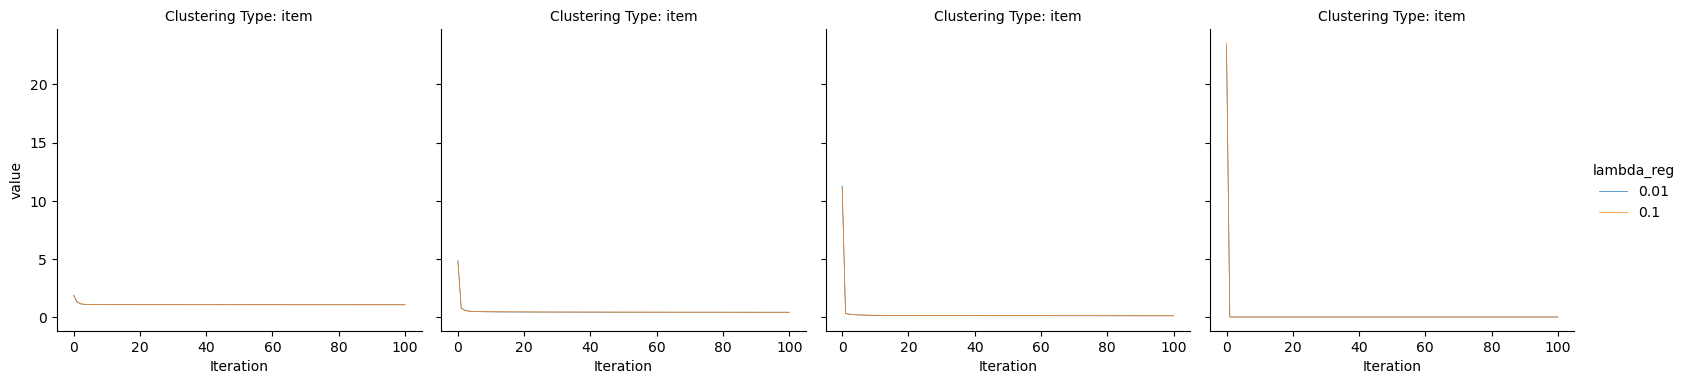

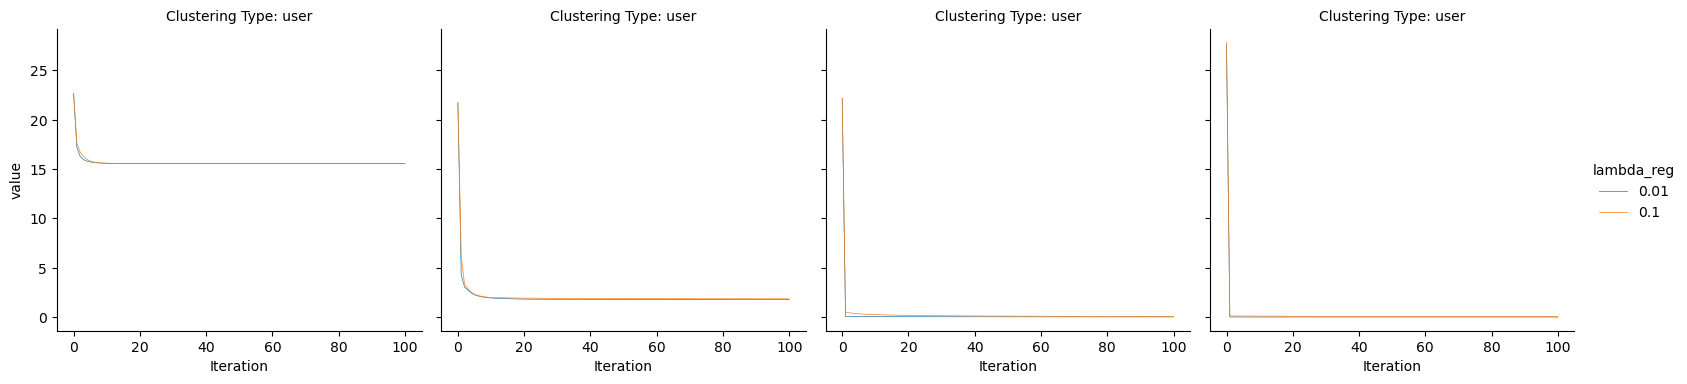

In [69]:
for clustering_type in ALS_melt['clustering_type'].unique():
    df_filtered = ALS_melt[ALS_melt['clustering_type'] == clustering_type]
    
    # Create a FacetGrid for this subset
    g = sns.FacetGrid(df_filtered, col="k", hue="lambda_reg",
                      col_wrap=4, height=4)
    g.map(sns.lineplot, "Iteration", "value", errorbar=None, linewidth=0.5)
    
    # Adding a title for clarity
    plt.subplots_adjust(top=0.9)
    g.set_titles(f'Clustering Type: {clustering_type}')

    
    g.add_legend()
    plt.show()

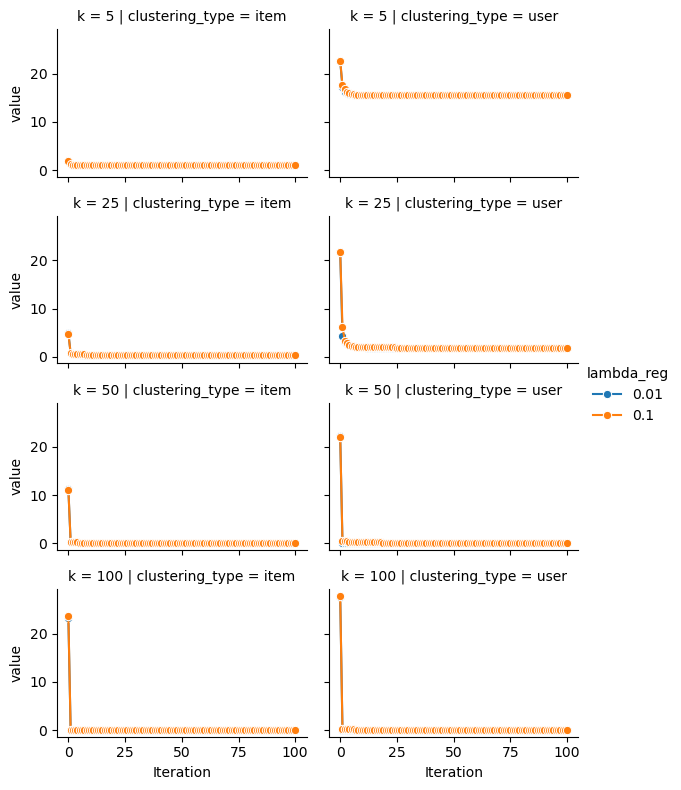

In [60]:
g = sns.FacetGrid(ALS_melt, col = 'clustering_type', row="k", hue="lambda_reg", aspect=1.5)
g.map(sns.lineplot, "Iteration", "value", marker="o", errorbar=None)
g.add_legend()
plt.show()

In [44]:
# Assuming 'errors' is your list of error values
errors = [0.3, 0.25, 0.2, 0.15, 0.1]  # Example data

# Convert to a DataFrame
errors_df = pd.DataFrame(errors, columns=['Error'])

# Optionally, if you want to plot these errors against their iteration number
errors_df['Iteration'] = range(1, len(errors)+1)
errors_df

,Error,Iteration
0,0.30,1
1,0.25,2
2,0.20,3
3,0.15,4
4,0.10,5


<Axes: xlabel='Iteration', ylabel='Error'>

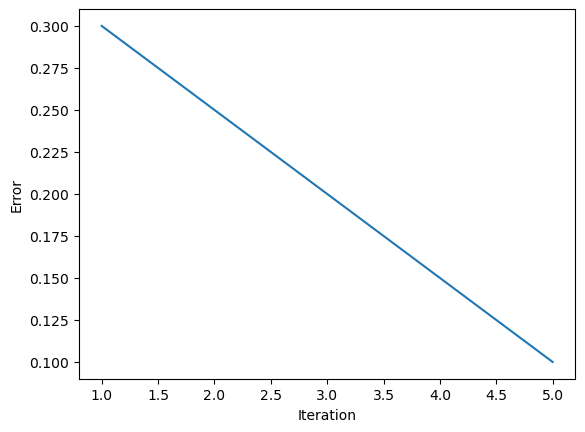

In [45]:
sns.lineplot(data=errors_df, x='Iteration', y='Error')

In [42]:

g = sns.FacetGrid(ALS_melt, col=['clustering_type', 'lambda_reg'], sharey=False, hue='k', height=5, aspect=1)

g.map(sns.lineplot, 'variable', 'value')
# g.set_axis_labels(y_var='Popularity', x_var='Time of day')
# g.add_legend(title='Categories')
# g.set_titles('User {col_name}')
plt.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

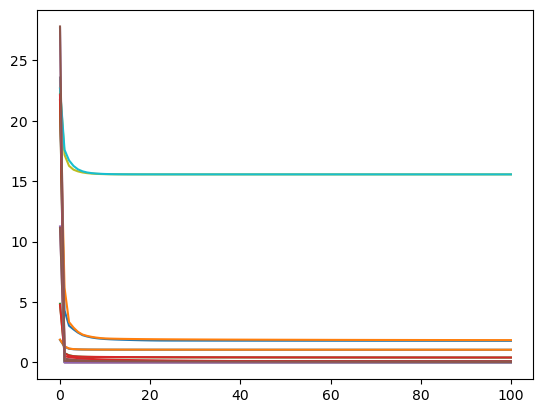

In [9]:
for index, row in ALS_output.iterrows():
    plt.plot(row['RMSE'], label=f'Line {index}')


# Making Recommendations

Arguably the other most important part of a recommender is the part that makes recommendations with the predicted ratings. The other largest sub-system of any recommender system is one that takes action on predicted ratings to make recommendations. What's considered a 'good' recommendation differs greatly depending on the goals in place for the recommender system as a whole. For example, if there are business incentives to promote articles of a certain category then 'good' recommendations are ones that a user will interact with and that further business goals. To ensure that our evaluation was comprehensive, we created a basic system to make recommendations on which we improved upon. 

## Metrics of Success
Recommendations can be evaluated by several success metrics: novelty, coverage and serendipity to name a few. Novelty is a measure of the newness of a recommendation. Coverage is a measure of how much of the catalogue is represented in recommendations. Serendipity measures both the newness of recommendations and how exciting they are. An example of a serendipitous recommendation would be if a user generally reads stories about sports in the united states and is then recommended a story about a lesser known sport from a different country they were unaware of. Improving and evaluating the serendipity of recommendations is both difficult and not agreed upon, therefore we chose the following ____ (research serendipity calculations) 

### Implementation of metrics

* To understand the coverage of our recommendations, we took the summation of all recommendations made and then determined the portion of the overall catalogue that was comprised of the recommendations. 
* To calculate the novelty of our recommendations, we utilized a vector similarity of item features to determine how similar recommended items were to those that were previously rated in addition to the popularity of articles.
* To calculate serendipity, we ___  

### Considering Edge Cases
In addition to improving the quality of recommendations in the directions that we deemed 'good' we also had to consider a couple different edge cases to improve the robustness of our systems. One such edge case that we explored was how we might deal with users that have ranked every available item, users that haven't ranked any items, or ones without many features to go off of.

### Basic Implementation of Recommender Step
For matrix factorization methods like gradient descent and alternating least squares, the most simple form of retrieval is to look at the highest n ratings present in a row of $\hat{R}$. This way of providing recommendations while simple is prone to providing recommendations of previously viewed items to users which immediately decreases its quality. 

### Improvements
Improving the quality of recommendations from ratings created by matrix factorization methods like ALS and SGD is a varied process. Since there's no 'best' way to recommend items we focused on improving recommendations in a few contexts: improving recommendations for a specific business goal, making recommendations more personal and adding another step to make intra-cluster recommendations. 

As mentioned previously, one of our first goals for improving recommendations was to avoid recommending items that a user has already rated. The way we implemented this was by utilizing the hash maps that are made during matrix creation to easily subset out viewed items from the set of recommendations prior to sorting it for the highest ratings.




### Making Recommendations : Utilizing Item Features

Current thoughts is leaning towards some weighted sum score for each item, like a feature similarity + dissimilarity + predicted ratings thingaling 

One way that we improved the quality of recommendations was to utilize both latent factors and given features from users and items to  
We further experimented on improving recommendations by utilizing the existing features alongside latent factors generated during matrix factorization for both users and items. Features were placed inside of several KNN models where a vector similarity could be used on highly rated and seen items to introduce the usage of features in similarity. User features were used to get the similar users and find recommendations that way.

In [1]:
# Import necessary libraries and load functions
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import matrix_modules

def calculate_coverage(items_recommended, items_present):
    """ 
    Calculates the coverage of recommendations made.

    Args:
        items_recommended (int) : The total number of items that are recommended to users.
        items_present (int) : The total number of items present in the catalog.

    Returns:
        coverage (float) : Returns the percent coverage of the catalog.
    """

    if items_recommended > items_present:
        return 1   
    else:
        return items_recommended / items_present

def calculate_novelty(recommendations, item_features, max_popularity):
    """
    Calculates the novelty of recommendations. Since novelty can be a measure of how popular items are 
    we calculate novelty by 1 - popularity(i) / max popularity
    """
    # Here we would just want to subset the recommendations made in the news features for their popularity and do calculations off of that
    # Iterate over all recommendations that are being made
    novelty_scores = []
    for recommendation in recommendations:

        # Recommendation is an index so we subset the item features for that index and get the popularity there 
        novelty_scores.append(1 - (item_features.loc[recommendation, 'popularity'] / max_popularity))

    return novelty_scores



In [2]:

user_features = pd.read_csv("../MIND_large/csv/user_features.csv", index_col=0)
item_features = pd.read_csv("../MIND_large/csv/item_features.csv", index_col=0).drop(columns=["Unnamed: 0", "travel.1"])


In [3]:
def prepare_features(user_features, item_features, clustering, n_neighbors):
    """ 
    Prepares user and item features depending on the clustering type into a format needed for recommending items.
    Initially the user and item features are rearranged to be more efficient for the recommendation step and then 
    grouping of features is done depending on clustering. Once grouping of features has been done the features are placed in
    knn models. 
    
    Additionally applies feature grouping depending on the clustering
    """
    # Get the list of category and subcategory columns.
    cols = item_features.iloc[:, 4:-1].columns
    cols.sort_values()
    item_features = item_features.drop(columns=['title', 'abstract'])

    item_clusters = item_features['cluster'] 
    item_popularity = item_features['popularity']
    item_ids = item_features['news_id']


    user_clusters = user_features['cluster']
    user_median = user_features['median_time']
    user_ids = user_features['user_id']

    item_features = item_features[cols]
    user_features = user_features[cols]
    # [item_ids, item_clusters, item_popularity, item_features]
    # [user_ids, user_clusters, user_median, user_features]
    item_features = pd.concat([item_ids, item_clusters, item_popularity, item_features], axis=1)
    user_features = pd.concat([user_ids, user_clusters, user_median, user_features], axis=1)
    
    item_features_knn = NearestNeighbors(n_neighbors=n_neighbors, metric = 'euclidean')
    user_features_knn = NearestNeighbors(n_neighbors=n_neighbors, metric = 'euclidean')

    if clustering=="user":
        user_features = user_features.groupby('cluster').agg(sum).reset_index()

    if clustering=="item":
        cols = item_features.columns
        item_features = item_features.groupby('cluster').agg(sum).reset_index()
        item_features = item_features[cols]

    item_features_knn.fit(item_features.iloc[:, 1:])
    user_features_knn.fit(user_features.iloc[:, 1:])

    return user_features, item_features, user_features_knn, item_features_knn

user_features, item_features, user_features_knn, item_features_knn = prepare_features(user_features, item_features, 'item', 5)

In [19]:
user_features.head()

,user_id,cluster,median_time,autos,entertainment,finance,foodanddrink,games,health,kids,...,voices,watch,weatherfullscreenmaps,weathertopstories,weight-loss,weightloss,wellness,wines,wonder,yearinoffbeatgoodnews
0,U1,37,0.375000,0.000000,0.236111,0.111111,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,U100,43,0.250000,0.069767,0.046512,0.046512,0.116279,0.0,0.116279,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,U1000,37,0.375000,0.000000,0.000000,0.000000,0.111111,0.0,0.000000,0.0,...,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,U10000,16,0.291667,0.011494,0.022989,0.137931,0.264368,0.0,0.114943,0.0,...,0.02381,0.0,0.0,0.000000,0.0,0.0,0.011905,0.0,0.0,0.0
4,U100005,35,0.500000,0.000000,0.000000,0.043011,0.225806,0.0,0.021505,0.0,...,0.00000,0.0,0.0,0.032258,0.0,0.0,0.010753,0.0,0.0,0.0


In [20]:
item_features.head()

,news_id,cluster,popularity,autos,entertainment,finance,foodanddrink,games,health,kids,...,voices,watch,weatherfullscreenmaps,weathertopstories,weight-loss,weightloss,wellness,wines,wonder,yearinoffbeatgoodnews
0,N3018N51256N78235N24850N95557N20278N9298N10896...,0,225399,3.0,2.0,5.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,N51947N46520N72751N5219N41917N58905N117941N116...,1,267647,55.0,80.0,91.0,1137.0,0.0,99.0,1.0,...,5.0,0.0,0.0,27.0,1.0,0.0,13.0,0.0,0.0,1.0
2,N5771N52012N64209N107808N5532N66010N120528N325...,2,180207,789.0,2.0,43.0,8.0,0.0,20.0,0.0,...,0.0,0.0,0.0,81.0,0.0,0.0,9.0,0.0,0.0,0.0
3,N93187N27233N95521N17952N68015N95120N61974N699...,3,302569,0.0,5.0,13.0,3.0,0.0,5.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,N117551N93333N70495N81976N40210N21320N37683N24...,4,165304,4.0,2.0,30.0,13.0,0.0,6.0,0.0,...,3.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Set up the ratings matrix
print("Loading Dataset")
full_ratings, news, users = matrix_modules.load_dataset_for_matrix()

print("Getting Ratings Matrix")
R, item_idx, user_idx = matrix_modules.create_item_cluster_mat(full_ratings, news, num_users=len(users), isALS=True, num_clusters=len(news['cluster'].unique()))
item_idx = {num : sorted(list(users)) for num, users in item_idx.items()}
user_idx = {user_id : sorted(list(ratings)) for user_id, ratings in user_idx.items()}
seen = {user_id : set(ratings) for user_id, ratings in user_idx.items()}
K = 5
I = len(user_idx) 
M = len(item_idx)
U = np.random.uniform(0, 1, size=K*I).reshape((K, I))
V = np.random.uniform(0, 1, size=K*M).reshape((K, M))
print("Starting ALS")
U, V, track_error, track_update = matrix_modules.alternating_least_squares(U, V, R, user_idx, item_idx, max_iterations=10)
R_hat = U.T @ V

Loading Dataset
Getting Ratings Matrix
Starting ALS


Starting ALS iterations: 100%|██████████| 10/10 [01:10<00:00,  7.00s/it]


In [10]:
def collaborative_filter(R, user_index, ratings_df, user_features, user_similarity_knn, seen):
    """
    Uses vector similarity to find similar users and their corresponding indices in the ratings matrix
    
    Args:
        R (np.ndarray) : The predicted user item matrix containing ratings.
        user_index (int) : A row index in the ratings matrix corresponding to a user. This is also used to get their features 
            from the user features dataset.
        ratings_df (pd.DataFrame) : The dataframe of ratings grouped by user id loaded in with load_dataset_for_matrix() used to get the users ID.
        user_similarity_knn (sklearn.neighbors.Knearestneighbors (something)) : The knn model fit on user feature vectors to pull similar indices from.
        seen (dict) : A dictionary containing a list of viewed item indices in R for users.
    Returns:
        items_to_rec (set) : A set of item indices to recommend based off of similar users' interactions.
    """
    # Get the users row from the item features data frame.
    user_row = user_features[user_features['user_id'] == ratings_df.iloc[user_index, 0]]

    # Get the indices of similar users in the ratings matrix. 
    _, indices = user_similarity_knn.kneighbors(user_row.iloc[:, 1:])

    # Initialize an empty set to hold onto item indices.
    items_to_rec = set()

    # Iterate over all other user indices.
    for idx in indices[0][1:]:
        
        # Get the user at idx sorted items by using the seen dictionary.
        sorted_rating_indices = np.argsort(R[idx, list(seen[idx])], axis=0)[::-1]

        # For their top 5 items, add it to the set of items to recommend.
        for item in sorted_rating_indices[:5]:
            items_to_rec.add(item)
    
    # Return items to recommend.
    return items_to_rec

# need to update the filtering step to ensure that theres at least 5 items, even if already seen

def content_filter(user_idx, seen, item_features, item_features_knn):
    """
    Introduces content filtering into the recommendation step by finding similar items to the ones already rated by the user.

    Args:
        user_idx (int) : The users index to get their seen items.
        seen (dict) : The viewed item dictionary.
        item_features (pd.DataFrame) : The item feature dataset used for vector similarity.

    Returns:
        items_to_rec (set) : A set of item indices to recommend based off of similar users' interactions.
    """
    # Initialize an empty set to hold onto item indices.
    items_to_rec = set()

    # Get a list of rated items for the user being recommended to.
    rated = list(seen[user_idx])

    # Iterate over the items finding similar items using the knn model.
    for item_idx in rated:
        _, indices = item_features_knn.kneighbors(item_features.iloc[item_idx, 1:].to_frame().T)

        # Add all similar items to the list of items to recommend.
        for index in indices[0][1:]:
            items_to_rec.add(index)
    
    # Return the list.
    return items_to_rec

def calculate_weights(user_feature_vector, item_indices, item_features):
    """
    Calculates each items rating weight by taking it's features dot product with the users features, then returns the weights.
    
    Args:
        user_feature_vector (pd.DataFrame) : A row from the user features dataframe containing a users features.
        item_indices (set) : A set containing items for recommendation learned through hybrid filtering.
        item_features (pd.DataFrame) : The item features dataframe containing rows for each item and its features.

    Returns:
        weights (np.ndarray) : Returns the weights generated by the feature vector calculations.
    """
    # Take the user feature vector and remove the user_id, cluster and median_time columns, then make it into a numpy array and reshape it.
    user_weights = user_feature_vector.iloc[0, 3:].to_numpy().reshape(-1, 1).T

    # Initialize an empty array for the weights.
    weights = []

    # Iterate over the items that have been collected for the user.
    for item_index in item_indices:

        # Find the items features and take its dot product with the users weights.
        item_weights = item_features.iloc[item_index, 3:].to_numpy().reshape(-1, 1)
        weight = user_weights @ item_weights
        weights.append(weight)
    
    # Return the item weights.
    return weights 

def filer_recommendations(sorted_indices, seen, user_index):
    """
    Filters the recommendations to exclude those that have already been rated by the user
    """
    viewed_items = seen[user_index]
    # Create an empty list to populate with recommendable indices.
    recommendable_items = []

    # Sort through all indices that are recommendable.
    for index in sorted_indices:

        # If the index corresponds with one that has not already been viewed, add it to the list of recommendable items.
        if index not in viewed_items:
            recommendable_items.append(index)
    
    # If the recommendable items list is empty, return the sorted indices. 
    if not recommendable_items:
        recommendable_items = sorted_indices
        print("User has interacted with all possible items")        
    
    # If the recommendable items list is not empty, return it.
    return recommendable_items

def recommend_items(R, seen, user_index, ratings_df, user_features, item_features, user_similarity_knn, item_features_knn):
    """ 
    Recommends items to a user at user_index utilizing hybrid filtering. Collaborative and content filtering utilize separate knn models fitted 
    on feature data for obtaining similar items to those already rated or those that similar users like. These items features are then compared against the users
    features to create weights. Weights are then applied to predicted ratings and the top items are returned.   

    Args:
        R (np.ndarray) : The completed user item matrix.
        seen (dict) : A dictionary containing users and seen items.
        user_index (int) : The index of the user being recommended items.
        ratings_df (pd.DataFrame) : The dataframe of ratings grouped by user id loaded in with load_dataset_for_matrix() used to get the users ID.
        user_features (pd.DataFrame) : The user features dataframe.
        item_features (pd.DataFrame) : The item features dataframe.
        user_similarity_knn (sklearn.neighbors.KNeighborsRegressor) : A fitted knn model on user features for collaborative filtering.
        item_features_knn (sklearn.neighbors.KNeighborsRegressor) : A fitted knn model on item features for content filtering.

    Returns:
        ratings_overall (list) : A list of items to return as recommendations.
    """
    # Use collaborative filtering to obtain items that similar users like.
    collaborative_items = collaborative_filter(R, user_index, ratings_df, user_features, user_similarity_knn, seen)

    # Use content filtering to find items similar to what the user has interacted with.
    content_items = content_filter(user_index, seen, item_features, item_features_knn)

    # Turn all items into a list.
    all_items = list(collaborative_items)+ list(content_items)

    # Filter items to remove those that the user has already seen.
    recommendable_items = filer_recommendations(all_items, seen, user_index)

    # Transform items into a set to sort them by index and then back into a list.
    items = list(set(recommendable_items))

    # Get the users feature row for calculating weights.
    user_row = user_features[user_features['user_id'] == ratings_df.iloc[user_index, 0]]

    # Calculate the predicted ratings' weights to include user preferences in recommendations.
    weights = calculate_weights(user_row, items, item_features)

    # Get the row of predicted ratings.
    ratings = R[1, items]
    ratings_overall = []

    # Iterate over all ratings multiplying each by its corresponding weight
    for i in range(len(weights)):
        ratings_overall.append(weights[i][0] * ratings[i])
    
    potential_recommendations = {items[i] : ratings_overall[i][0] for i in range(len(weights))}
    return potential_recommendations

# now to update the recommendation step such that it can manage business intentions as well as maybe use vector dissimilarity


In [44]:
print(seen[1])

{0, 1, 2, 3, 4, 5, 7, 11, 13, 14, 15, 16, 18, 21, 22, 23, 25, 27, 28, 29}


In [11]:
recommend_items(R_hat, seen, 1, full_ratings, user_features, item_features, user_features_knn, item_features_knn )

{6: 140.9513513374127,
 8: 154.58347660407202,
 9: 57.4063658437129,
 10: 229.26969244441077,
 12: 1028.6436383719326,
 17: 85.44336774773161,
 20: 83.69527635109074,
 24: 321.9583461156339}